# Coursework for Cardiac MR Image Segmentation (2021-2022)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device  :',device)

device  : cuda


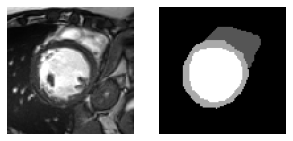

(96, 96)


In [ ]:

import os
import cv2 #import OpenCVfrom matplotlib import pyplot as plt
import matplotlib.pyplot as plt


def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

data_dir = '/content/drive/MyDrive/data/train/'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)
print(image.shape)


Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [ ]:

import torch
import torch.utils.data as data
import cv2
import os
from glob import glob
path = '/content/drive/MyDrive/data/train'


class TrainDataset(data.Dataset):
    def __init__(self, root=path):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        #print(self.img_files)
        self.mask_files = []
        #print(self.img_files)
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()    #tensor vlaues for data( image) and label( mask) is returned.

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(),img_path

    def __len__(self):
        return len(self.img_files)


### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

The model used is UNEt with modifications

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels, mid_channels = None):
    if not mid_channels:
            mid_channels = out_channels
    return nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):

    def __init__(self, n_class=4):
        super().__init__()

        self.dconv_pre = double_conv(1,3)       
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512) 
       #self.dconv_down5 = double_conv(512, 1024)       

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):

        convpre = self.dconv_pre(x) #not maxpooling here
        conv1 = self.dconv_down1(convpre)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out
"""
class CNNSEG(nn.Module):

    def __init__(self, n_class=4):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 3)
        self.dconv_down2 = double_conv(3, 64)
        self.dconv_down3 = double_conv(64, 128)
        self.dconv_down4 = double_conv(128, 256)
        self.dconv_down5 = double_conv(256, 512)          

        self.maxpool = nn.MaxPool2d(2) #kernel size two..stride = none

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        
       # self.dconv_up3 = double_conv(256 + 512, 256)
        #self.dconv_up2 = double_conv(128 + 256, 128)
        #self.dconv_up1 = double_conv(128 + 64, 64)
        self.dconv_up4 = double_conv(512+512, 512)
        self.dconv_up3 = double_conv()
        self.dconv_up2 = double_conv(512+512, 512)
        self.dconv_up1 = double_conv(512+512, 512)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4) 

        conv5 = self.dconv_down5(x)

        x = self.upsample(conv5)        #left with 512 channels and ..becomes 12 * 12
        x = torch.cat([x, conv4], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out
"""

#https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py

model = UNet() # We can now create a model using your defined segmentation model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels, mid_channels = None):
    if not mid_channels:
            mid_channels = out_channels
    return nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):

    def __init__(self, n_class=4):
        super().__init__()

        self.dconv_pre = nn.Sequential(nn.Conv2d(1, 3, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(3),
                                       nn.ReLU(inplace=True))      
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512) 
       #self.dconv_down5 = double_conv(512, 1024)       

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):

        convpre = self.dconv_pre(x) #not maxpooling here
        conv1 = self.dconv_down1(convpre)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

model = UNet()

In [ ]:



model = model.to(device)

model

UNet(
  (dconv_pre): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

In [ ]:
from torchsummary import  summary
#help to view the visualisation of the model

summary(model,input_size=(1,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 96, 96]              30
       BatchNorm2d-2            [-1, 3, 96, 96]               6
              ReLU-3            [-1, 3, 96, 96]               0
            Conv2d-4           [-1, 64, 96, 96]           1,792
       BatchNorm2d-5           [-1, 64, 96, 96]             128
              ReLU-6           [-1, 64, 96, 96]               0
            Conv2d-7           [-1, 64, 96, 96]          36,928
       BatchNorm2d-8           [-1, 64, 96, 96]             128
              ReLU-9           [-1, 64, 96, 96]               0
        MaxPool2d-10           [-1, 64, 48, 48]               0
           Conv2d-11          [-1, 128, 48, 48]          73,856
      BatchNorm2d-12          [-1, 128, 48, 48]             256
             ReLU-13          [-1, 128, 48, 48]               0
           Conv2d-14          [-1, 128,

### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

In [ ]:

import torch.optim as optim
from torch.optim import lr_scheduler

"""
def dice_loss(pred,target, smooth = 1.):

    pred = pred.contiguous()
    target = target.contiguous()    
    
    #When you call contiguous(), it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.

    #Normally you don't need to worry about this. You're generally safe to assume everything will work, and wait until you get a RuntimeError: input is not contiguous where PyTorch expects a contiguous tensor to add a call to contiguous().

    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()


criterion = nn.CrossEntropyLoss()

# so we have two types of loss the dice loss and cross entropy loss

def optimizer():
  return optim.Adam(filter( lambda p:p.requires_grad,model.parameters()),lr=1e-4)

optimizer_ft = optimizer()
def exp_lr_scheduler():
  return lr_scheduler.StepLR(optimizer_ft,step_size=30,gamma=0.1)
"""


"\ndef dice_loss(pred,target, smooth = 1.):\n\n    pred = pred.contiguous()\n    target = target.contiguous()    \n    \n    #When you call contiguous(), it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.\n\n    #Normally you don't need to worry about this. You're generally safe to assume everything will work, and wait until you get a RuntimeError: input is not contiguous where PyTorch expects a contiguous tensor to add a call to contiguous().\n\n    \n\n    intersection = (pred * target).sum(dim=2).sum(dim=2)\n    \n    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))\n    \n    return loss.mean()\n\n\ncriterion = nn.CrossEntropyLoss()\n\n# so we have two types of loss the dice loss and cross entropy loss\n\ndef optimizer():\n  return optim.Adam(filter( lambda p:p.requires_grad,model.parameters()),lr=1e-4)\n\noptimiz

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [ ]:
# https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py

import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)


In [ ]:
model = UNet()

In [ ]:
from torch.utils.data import DataLoader
from collections import defaultdict
import time
import argparse
from tqdm import tqdm
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
"""
def print_metrics(metrics, epoch_samples, phase='train'):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def calc_loss(pred,target,metrics,bce_weight=0.5) :
    #bce = F.binary_cross_entropy_with_logits(pred,target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred,target) 

    #loss = bce * bce_weight + dice * (1 - bce_weight)
    

    metrics['bce'] += 1#bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += 1#loss.data.cpu().numpy() * target.size(0)

    return metrics['loss']
"""
"""
def dice_coef_binary_4cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 4 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = torch.flatten(F.one_hot(torch.cast(y_true, 'int32'), num_classes=4)[...,1:])
    y_pred_f = torch.flatten(y_pred[...,1:])
    intersect = F.sum(y_true_f * y_pred_f, axis=-1)
    denom = F.sum(y_true_f + y_pred_f, axis=-1)
    return F.mean((2. * intersect / (denom + smooth)))


def dice_coef_binary_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_binary_4cat(y_true, y_pred)

"""
checkpoint_path = "checkpoint.pth"
data_path = '/content/drive/MyDrive/data/train/'
num_workers = 4
batch_size = 4
"""
#what does data loader do?
Dataset stores the samples and their corresponding labels, and 
DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

"""
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
optimizer_fn = optim.Adam(model.parameters(),lr = 3e-4)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
scheduler_fn = lr_scheduler.StepLR(optimizer_fn,step_size=30,gamma=0.1)

loss_fn = nn.CrossEntropyLoss()
if isinstance(loss_fn,torch.nn.Module): ##just to be sure that criterion is on the correct device.
  loss_fn.to(device)

def train_net(model,
              device,
              epochs: int =10,
              batch_size: int = 1,
              learning_rate: float = 3e-4,
              optimizer = optimizer_fn,
              scheduler = scheduler_fn,
              criterion = loss_fn,
              #val_percent: float = 0.1,
              #save_checkpoint: bool = True,
             # img_scale: float = 0.5,
              amp: bool = False
):
#print("training the network...")
# Fetch images and labels.
  model.train()  #funciton of the module superclass ..sets the model to train.
  train_set = TrainDataset(data_path)
  training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
 # https://github.com/milesial/Pytorch-UNet/blob/master/train.py 


  global_step = 0
  steps =[]
  losses=[]
  for epoch in range(epochs) :
    #torch.set_grad_enabled(True)
    epoch_samples = 0
    epoch_loss=0
    metrics = defaultdict(float)
    since = time.time()
  
    with tqdm(len(train_set), desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:     
      for iteration, sample in enumerate(training_data_loader):
      #for batch in training_data_loader:
          img, mask = sample

          #print('\nimage size :', img.shape)
          print('mask size :',mask.shape)
          img=img.unsqueeze(1)
          print('\nimage size :', img.shape)
          img  = img.to(device = device)
          #https://discuss.pytorch.org/t/only-batches-of-spatial-targets-supported-non-empty-3d-tensors-but-got-targets-of-size-1-1-256-256/49134/18 
          mask = mask.squeeze(1)
          mask = mask.to(device,dtype = torch.long)

      
          #mask = F.one_hot(mask,4).permute(0,3,1,2).float()
          #print(mask.shape)
          """
          torch.cuda.amp and torch provide convenience methods for mixed precision,
          where some operations use the torch.float32 (float) datatype and other operations use torch.float16 (half).
          Some ops, like linear layers and convolutions, are much faster in float16. 
          Other ops, like reductions, often require the dynamic range of float32. 
          Mixed precision tries to match each op to its appropriate datatype.
          """
          #with torch.cuda.amp.autocast(enabled = amp)
          out  = model(img)
          #print(out.shape)
          optimizer.zero_grad()
          cross_entropy_loss = criterion (out,mask) 
          #dice_loss = dice_coef_binary_loss(mask,out)
          dice= dice_loss(F.softmax(out, dim=1).float(), F.one_hot(mask, 4).permute(0, 3, 1, 2).float(),multiclass=True)
          loss = dice
          #loss = cross_entropy_loss
    
    # Then write your BACKWARD & OPTIMIZE below
    # Note: Compute Loss and Optimize
    #loss = criterion(out,mask)
    #loss_value = loss.item()
    #train_losses.append(loss_value)
    #loss.backward()
          

         # optimizer.zero_grad(set_to_none=True)
         # grad_scaler.scale(loss).backward()
         # grad_scaler.step(optimizer)
         # grad_scaler.update()

          pbar.update(img.shape[0])
          global_step += 1
          epoch_loss += loss.item()
          losses.append(loss.item())
          steps.append(global_step)
          loss.backward()
          optimizer.step()
          #experiment.log({
           #         'train loss': loss.item(),
            #        'step': global_step,
             #       'epoch': epoch
               # })
          print('train loss',loss.item(),' step :',global_step,' epoch :',epoch)
          pbar.set_postfix(**{'loss (batch)': loss.item()})
  plt.plot(steps[1::2],losses[1::2],'.r-')
  plt.xlabel("step")
  plt.ylabel("loss")
  x1,x2,y1,y2 = plt.axis()  
  plt.axis((x1,x2,0,1))
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5, forward=True)
  fig.set_dpi(100)
  plt.show()
  return model, losses
model, losses = train_net(model,device)
torch.save(model.state_dict(), checkpoint_path)

    

# Validation

In [ ]:
import numpy as np
from torch.autograd import Variable
print(os.getcwd())

/content


In [ ]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
Learned_model = model

num_workers = 4
batch_size = 2
loss_list = []
Learned_model.to(device)  #Change
val_set = TrainDataset(data_path)  #Change
data_path = '/content/drive/MyDrive/data/train/'
#criterion = nn.CrossEntropyLoss()

Learned_model.eval()  #Change

for image,mask in test_data_loader:
        #print(image.shape,mask.shape)
        image = image.to(device)
        image = image.unsqueeze(1)
        
        mask = mask.to(device,dtype = torch.long)
        #####PLEASE COMPLETE THE FOLLOWING CODE#####
        #insert the neccessary lines of code to complete the training loop here 
        #(approx 5 lines of code)
        ############################################
        out = Learned_model(image)
       # loss = criterion(out,mask.long())
        loss = dice_loss(F.softmax(out, dim=1).float(), F.one_hot(mask, 4).permute(0, 3, 1, 2).float(),multiclass=True)
        print('loss score for image : ',loss.item())
        loss_list.append(loss.item())
        out_np = torch.max(out,1).indices.cpu().detach().numpy()
        mask_np = mask.cpu().detach().numpy()
        image_np = image.cpu().detach().numpy()
        print(out_np[0].shape,mask_np.shape)
        print(image_np[0].shape,mask_np.shape)
        for i in range(1):
            show_image_mask(image_np[i,0], out_np[i], cmap='gray')
            plt.pause(1)
print(loss_list)
#for iteration, sample in enumerate(test_data_loader):
#   img = sample
#   print(img.shape)
    
#    plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
#    plt.pause(1)
#model.eval()

# Main code Test + Val

In [ ]:
from torch.utils.data import DataLoader
from collections import defaultdict
import time
import argparse
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler

val_data_path = '/content/drive/MyDrive/data/val'
data_path = '/content/drive/MyDrive/data/val'

num_workers = 4
batch_size = 2
epoch_train_losses=[]
epoch_val_losses = []

val_set = TrainDataset(val_data_path)  #Change
val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
optimizer_fn = optim.Adam(model.parameters(),lr = 3e-4)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
scheduler_fn = lr_scheduler.StepLR(optimizer_fn,step_size=30,gamma=0.1)

loss_fn = nn.CrossEntropyLoss()
if isinstance(loss_fn,torch.nn.Module): ##just to be sure that criterion is on the correct device.
  loss_fn.to(device)

def train_and_validate(model,
              device,
              epochs: int =10,
              batch_size: int = 1,
              learning_rate: float = 3e-4,
              optimizer = optimizer_fn,
              scheduler = scheduler_fn,
              criterion = loss_fn,
              #val_percent: float = 0.1,
              #save_checkpoint: bool = True,
             # img_scale: float = 0.5,
              amp: bool = False
):
  
  for epoch in range(epochs) :
    #torch.set_grad_enabled(True)

    since = time.time()
     #with tqdm(len(train_set), desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:     
    train_loss = 0.0
    model.train()
    for iteration, sample in enumerate(training_data_loader):
    #for batch in training_data_loader:
        img, mask = sample

  
        
        img=img.unsqueeze(1)
        img  = img.to(device = device)
        #https://discuss.pytorch.org/t/only-batches-of-spatial-targets-supported-non-empty-3d-tensors-but-got-targets-of-size-1-1-256-256/49134/18 
        mask = mask.squeeze(1)
        mask = mask.to(device,dtype = torch.long)

      
         
        out  = model(img)
          #print(out.shape)
        optimizer.zero_grad()
        cross_entropy_loss = criterion (out,mask) 
          #dice_loss = dice_coef_binary_loss(mask,out)
        dice= dice_loss(F.softmax(out, dim=1).float(), F.one_hot(mask, 4).permute(0, 3, 1, 2).float(),multiclass=True)
        #loss = dice
        loss = cross_entropy_loss
    
    # Then write your BACKWARD & OPTIMIZE below
    # Note: Compute Loss and Optimize
    #loss = criterion(out,mask)
    #loss_value = loss.item()
    #train_losses.append(loss_value)
    #loss.backward()
          

         # optimizer.zero_grad(set_to_none=True)
         # grad_scaler.scale(loss).backward()
         # grad_scaler.step(optimizer)
         # grad_scaler.update()

          #pbar.update(img.shape[0])
       
        
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

     #   print('train loss',loss.item(),' step :',global_step,' epoch :',epoch)
    
    val_loss =0.0
    model.eval()
    for image,mask in val_data_loader:
      #print(image.shape,mask.shape)
      image = image.to(device)
      image = image.unsqueeze(1)
        
      mask = mask.to(device,dtype = torch.long)
        #####PLEASE COMPLETE THE FOLLOWING CODE#####
        #insert the neccessary lines of code to complete the training loop here 
        #(approx 5 lines of code)
        ############################################
      out = model(image)
      loss = criterion(out,mask.long())
      #loss = dice_loss(F.softmax(out, dim=1).float(), F.one_hot(mask, 4).permute(0, 3, 1, 2).float(),multiclass=True)
      val_loss += loss.item() * image.size(0)
      out_np = torch.max(out,1).indices.cpu().detach().numpy()
      #mask_np = mask.cpu().detach().numpy()
      #image_np = image.cpu().detach().numpy()
      #print(out_np[0].shape,mask_np.shape)
      #print(image_np[0].shape,mask_np.shape)
      #print('Val loss',loss_list.item(),' step :',global_step,' epoch :',epoch)
      #for i in range(1):
          #show_image_mask(image_np[i,0], out_np[i], cmap='gray')
          #plt.pause(1)
    epoch_train_losses.append(train_loss / len(train_set))
    epoch_val_losses.append(val_loss/len(val_set))
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_set)} \t\t Validation Loss: {val_loss / len(val_set)}')
    
  return model

model =  train_and_validate(model,device,30)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 		 Training Loss: 0.5308473914861679 		 Validation Loss: 1.2195829033851624
Epoch 2 		 Training Loss: 0.3484025627374649 		 Validation Loss: 1.0112667798995971
Epoch 3 		 Training Loss: 0.2926463097333908 		 Validation Loss: 0.7242559671401978
Epoch 4 		 Training Loss: 0.25780790746212007 		 Validation Loss: 0.6995344400405884
Epoch 5 		 Training Loss: 0.22858039885759354 		 Validation Loss: 0.49097307324409484
Epoch 6 		 Training Loss: 0.19432607889175416 		 Validation Loss: 0.39546737968921664
Epoch 7 		 Training Loss: 0.1725316122174263 		 Validation Loss: 0.3514880478382111
Epoch 8 		 Training Loss: 0.15596081763505937 		 Validation Loss: 0.29465358555316923
Epoch 9 		 Training Loss: 0.14165190756320953 		 Validation Loss: 0.3004500806331635
Epoch 10 		 Training Loss: 0.13103242218494415 		 Validation Loss: 0.25059657990932466
Epoch 11 		 Training Loss: 0.11879841163754463 		 Validation Loss: 0.21621857285499574
Epoch 12 		 Training Loss: 0.10698643326759338 		 Validation L

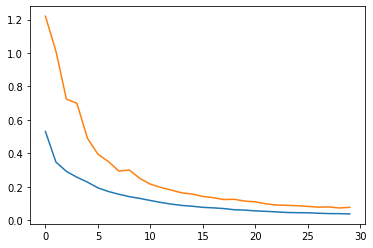

In [ ]:

plt.plot(epoch_train_losses)
plt.plot(epoch_val_losses)

### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [ ]:
import numpy as np
from torch.autograd import Variable
print(os.getcwd())

/content


In [ ]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
import re
data_path = '/content/drive/MyDrive/data/test/'
num_workers = 2
batch_size = 1
Learned_model= model
test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)
Learned_model.eval()
for iteration, sample in enumerate(test_data_loader):
    img,img_pth = sample
    #print(img.shape)
    print(img.size())
    img = img.unsqueeze(1)
    print(img.size())
    
    #img = x(img)

    img = img.to(device)
    out = Learned_model(img)
    out_np = torch.max(out,1).indices.cpu().detach().numpy()
    image_np = img.cpu().detach().numpy()
    print(img_pth[0])
   # print(re.split(r'\/',img_pth[0]))
    img_pth = re.split(r'\/',img_pth[0])
    print(img_pth)
    path = os.path.join('',img_pth[-1])
    print(path)
    cv2.imwrite(np.float32(path),out*85)   #
    for i in range(1):
            show_image_mask(image_np[i,0], out_np[i], cmap='gray')
            plt.pause(1)

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr161.png
['', 'content', 'drive', 'MyDrive', 'data', 'test', 'image', 'cmr161.png']
cmr161.png


ValueError: ignored

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [ ]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()

In [ ]:
well = "Well Boy"
print(well)

Well Boy
